# Multilayer Perceptron

In [18]:
import numpy as np
import random as rd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy import stats

## Loading Dataset

In [19]:
input_header = {"PROC_TRACEINFO" : "id",
                "OP070_V_1_angle_value": "angle_1",
                "OP090_SnapRingPeakForce_value" : "snap_ring_peak_force",
                "OP070_V_2_angle_value" : "angle_2",
                "OP120_Rodage_I_mesure_value" : "rodage_i",
                "OP090_SnapRingFinalStroke_value" : "snap_ring_final_stroke",
                "OP110_Vissage_M8_torque_value" : "vissage_m8_torque",
                "OP100_Capuchon_insertion_mesure" : "capuchon_insertion",
                "OP120_Rodage_U_mesure_value" : "rodage_u",
                "OP070_V_1_torque_value" : "torque_1",
                "OP090_StartLinePeakForce_value" : "start_line_peak_force",
                "OP110_Vissage_M8_angle_value" : "vissage_m8_angle",
                "OP090_SnapRingMidPointForce_val" : "snap_ring_midpoint_force",
                "OP070_V_2_torque_value" : "torque_2"}
output_header = {"PROC_TRACEINFO" : "id",
                 "Binar OP130_Resultat_Global_v" : "result"}

train_input = pd.read_csv("./data/train_inputs.csv", header=0).rename(columns=input_header)
train_output = pd.read_csv("./data/train_output.csv", header=0).rename(columns=output_header)

train_input_ = train_input[train_input.columns[~train_input.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_, train_output["result"], test_size = 0.3, random_state = 123)

# Scale data (MLP is very sensitive to scaling)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## MLP

In [20]:
# Create model
mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=400)
mlp_model.fit(X_train, y_train)

# Prediction
y_pred = mlp_model.predict(X_test)

# Evaluation
metrics.accuracy_score(y_test, y_pred)

0.9911154031868662

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


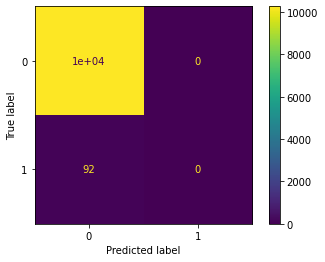

In [21]:
# Compute confusion matrix
M = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = M.ravel() # True/False negative/positive

# Plot confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()

Once again: overfitting due to unbalanced classes !

## MLP with Balanced Classes

### Remove Individuals

In [26]:
# Copy dataset
train_input_remove = train_input.copy()
train_output_remove = train_output.copy()

# Select index
defect_index = train_output.index[train_output["result"] == 1].tolist()
valid_index = train_output.index[train_output["result"] == 0].tolist()

# Randomly remove some valid individuals
rd.shuffle(valid_index) # Shuffle in order to eliminate "production correlation"
train_input_remove = train_input_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]
train_output_remove = train_output_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]

# Create new datasets
train_input_remove = train_input_remove[train_input_remove.columns[~train_input_remove.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_remove, train_output_remove["result"], test_size = 0.3, random_state = 123)

# Scale data (MLP is very sensitive to scaling)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create model
mlp_balanced_model = MLPClassifier(
    solver='sgd',
    activation='tanh', 
    alpha=1e-2,
    batch_size=32,
    learning_rate='adaptive', 
    hidden_layer_sizes=(200,150,100,50), 
    random_state=1, 
    n_iter_no_change =12,
    early_stopping=True,
    max_iter=2000,
    verbose = False)

mlp_balanced_model.fit(X_train, y_train)

# Prediction
y_pred = mlp_balanced_model.predict(X_test)

# Evaluation
# cross_val_score(mlp_balanced_model, X_test, y_test, cv=5, scoring="accuracy")
metrics.accuracy_score(y_test, y_pred)

0.6666666666666666

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


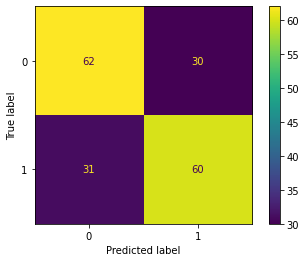

In [27]:
# Compute confusion matrix
M = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = M.ravel() # True/False negative/positive

# Plot confusion matrix
plot_confusion_matrix(mlp_balanced_model, X_test, y_test)
plt.show()

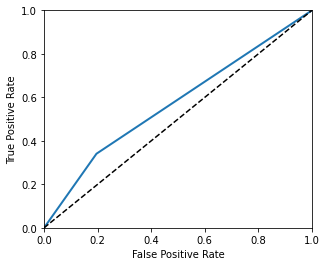

In [29]:
def plotROC(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

y_scores = cross_val_predict(mlp_balanced_model, X_test, y_test,  cv=5)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure().set_figwidth(4.8)
plotROC(fpr, tpr)
plt.show()

More realistic...

## MLP without Outliers

In [37]:
# Copy dataset
train_input_remove = train_input.copy()
train_output_remove = train_output.copy()

# Scale data (MLP is very sensitive to scaling and allow for a unique treshold)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Remove outliers
threshold = 3
outliers = np.array([], dtype = int)
for col_name in list(input_header.values())[1:]:
    z = np.abs(stats.zscore(train_input[col_name]))
    outliers = np.append(outliers, np.where(z > threshold))
outliers_no_duplicate = np.array([], dtype=int)
for i in range(np.size(outliers)):
    if(outliers[i] not in outliers_no_duplicate):
        outliers_no_duplicate = np.append(outliers_no_duplicate, outliers[i])
# np.size(outliers_no_duplicate)

# Select index
defect_index = train_output.index[train_output["result"] == 1].tolist()
for elmt in defect_index:
    if elmt in outliers_no_duplicate:
        defect_index.remove(elmt)
valid_index = train_output.index[train_output["result"] == 0].tolist()
for elmt in valid_index:
    if elmt in outliers_no_duplicate:
        valid_index.remove(elmt)

# Randomly remove some valid individuals
rd.shuffle(valid_index) # Shuffle in order to eliminate "production correlation"
train_input_remove = train_input_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]
train_output_remove = train_output_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]

# Create new datasets
train_input_remove = train_input_remove[train_input_remove.columns[~train_input_remove.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_remove, train_output_remove["result"], test_size = 0.3, random_state = 123)


# Create model
mlp_balanced_model = MLPClassifier(
    solver='sgd',
    activation='tanh', 
    alpha=1e-2,
    batch_size=32,
    learning_rate='adaptive', 
    hidden_layer_sizes=(200,150,100,50), 
    random_state=1, 
    n_iter_no_change =12,
    early_stopping=True,
    max_iter=2000,
    verbose = False)
mlp_balanced_model.fit(X_train.values, y_train.values)

# Prediction
y_pred = mlp_balanced_model.predict(X_test.values)

# Evaluation
metrics.accuracy_score(y_test, y_pred)

0.536723163841808